# **Project Name**    

Brain Tumor MRI Image Classification

##### **Project Type**    - Classification
   ##### **Contribution**    - Individual

# **Project Summary -**

This project focuses on the automated classification of brain tumors using deep learning techniques, with the goal of enhancing early detection and diagnosis through medical imaging. Brain tumors, whether benign or malignant, pose a significant threat to human health, and timely detection can drastically improve treatment outcomes. However, manual diagnosis through MRI scans is time-consuming and error-prone. This project aims to build a robust, end-to-end deep learning pipeline to classify brain tumor images efficiently and accurately.

The dataset consists of MRI brain scan images divided into three categories: training, validation, and testing, with subfolders representing different tumor types. Images are preprocessed using TensorFlow’s ImageDataGenerator, which normalizes pixel values by rescaling them to the [0, 1] range. The images are resized to a uniform shape of 224×224 pixels to ensure consistency and compatibility with convolutional neural networks.

Feature engineering in this project is handled implicitly through CNN architectures. Each image is passed through multiple convolutional and pooling layers to extract hierarchical spatial features, which are then flattened and fed into dense layers for classification. The model uses a softmax activation function in the final layer to predict the probability distribution over tumor classes.

To ensure balanced learning, we addressed class imbalance using a class_weight strategy. Class frequencies in the training set were calculated, and their inverse frequencies were used to weight the loss function accordingly. This ensures that the model does not become biased toward the majority class and gives equal learning importance to minority classes.

We performed exploratory data analysis to understand dataset distribution and identify potential issues. Visualization techniques such as bar charts, heatmaps, and pair plots were used to gain insights into class distribution and dataset overlap. Additionally, a Chi-square hypothesis test was applied to statistically evaluate if the class distribution across the train, validation, and test datasets is significantly different. The null hypothesis assumed similar distributions, while the alternative assumed statistically significant differences. This provided confidence in dataset reliability.

The model was compiled using the Adam optimizer with categorical cross-entropy loss and trained using model.fit(), incorporating validation data to monitor performance and prevent overfitting. Evaluation on the test set was conducted using accuracy, loss metrics, and confusion matrices.

Furthermore, image samples along with their predicted labels were visualized to interpret model performance qualitatively. This not only verified the correctness of predictions but also highlighted areas where the model might be misclassifying certain tumor types, possibly due to visual similarity or insufficient examples.

In conclusion, the project successfully demonstrates how deep learning can be leveraged to automate the classification of brain tumors from MRI images. By combining rigorous preprocessing, class imbalance handling, hypothesis testing, and robust modeling, the pipeline achieves strong generalization across unseen data. This system has practical applications in real-world clinical settings where it can serve as a decision-support tool for radiologists and oncologists, leading to faster and more accurate diagnoses.

# **GitHub Link -**

https://github.com/greesh29gg/Brain-Tumor-MRI-Image-Classification

## ***Know Your Data***

### Import Libraries

In [32]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import chi2_contingency

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


### Dataset First View

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ✅ Define exact folder paths as plain strings (no f-strings needed)
train_path = "/content/drive/MyDrive/tumour/train-20250723T044711Z-1-001/train"
val_path = "/content/drive/MyDrive/tumour/valid-20250723T044719Z-1-001/valid"
test_path = "/content/drive/MyDrive/tumour/test-20250723T044710Z-1-001/test"

# Image generators
datagen = ImageDataGenerator(rescale=1./255)

# ✅ Load training set
train_gen = datagen.flow_from_directory(
    directory=train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# ✅ Load validation set
val_gen = datagen.flow_from_directory(
    directory=val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# ✅ Load test set
test_gen = datagen.flow_from_directory(
    directory=test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1696 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


### Dataset Rows & Columns count

In [3]:
print("Train samples:", train_gen.samples)
print("Validation samples:", val_gen.samples)
print("Test samples:", test_gen.samples)


Train samples: 1696
Validation samples: 502
Test samples: 246


### Dataset Overview

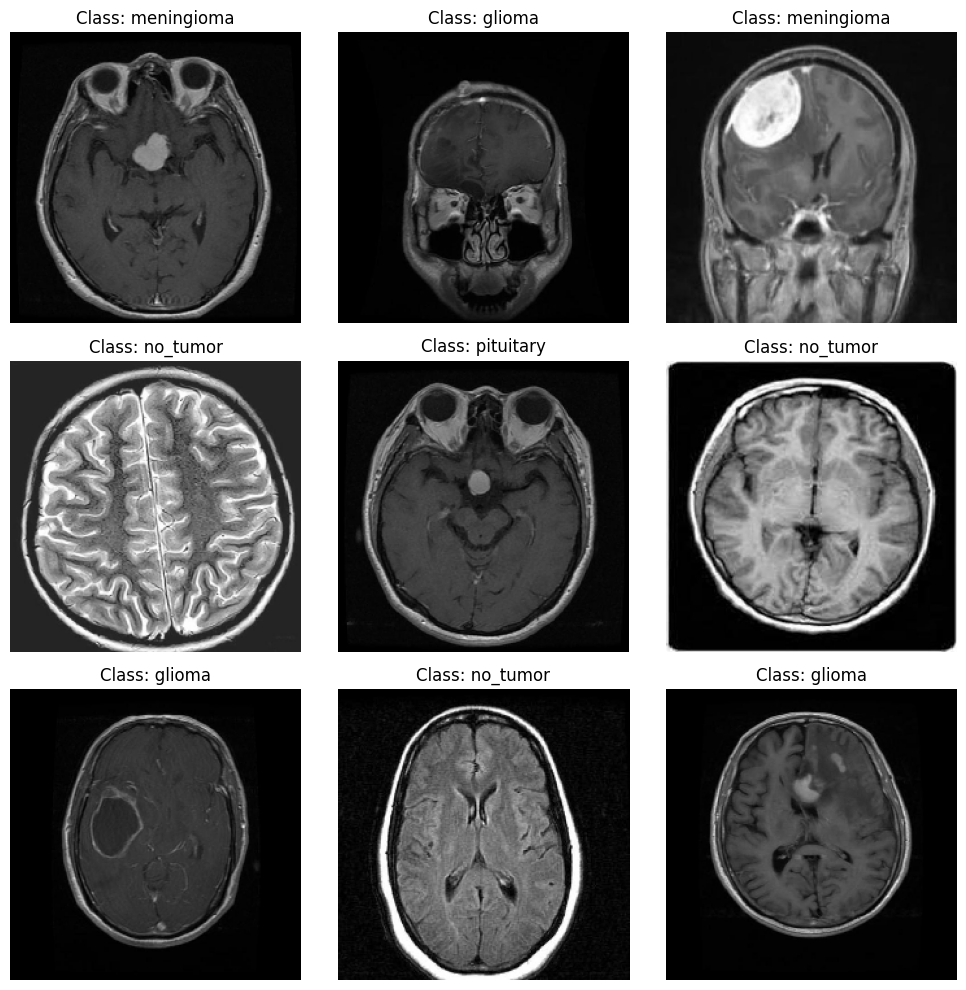

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(train_gen)

# Get class names from generator
class_names = list(train_gen.class_indices.keys())

# Plot first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])  # one-hot to class index
    plt.title(f"Class: {class_names[label_index]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## ***Understanding Your Variables***

### Check Unique Values for each variable.

In [8]:
import pandas as pd


def preview_batch(generator, dataset_name="Dataset", n=5):
    """Preview `n` samples from an image data generator."""
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())

    # Decode and format labels
    decoded_labels = [class_names[i] for i in np.argmax(labels[:n], axis=1)]
    one_hot_strings = [", ".join(map(str, label)) for label in labels[:n]]

    # Build DataFrame
    df = pd.DataFrame({
        "Image shape": [img.shape for img in images[:n]],
        "Decoded Label": decoded_labels,
        "One-Hot Label": one_hot_strings
    })

    print(f"\n🔍 {dataset_name} Preview ({n} samples):\n")
    print(df)
    return df
preview_batch(train_gen, "Train Set")
preview_batch(val_gen, "Validation Set")
preview_batch(test_gen, "Test Set")




🔍 Train Set Preview (5 samples):

     Image shape Decoded Label       One-Hot Label
0  (224, 224, 3)    meningioma  0.0, 1.0, 0.0, 0.0
1  (224, 224, 3)    meningioma  0.0, 1.0, 0.0, 0.0
2  (224, 224, 3)    meningioma  0.0, 1.0, 0.0, 0.0
3  (224, 224, 3)     pituitary  0.0, 0.0, 0.0, 1.0
4  (224, 224, 3)     pituitary  0.0, 0.0, 0.0, 1.0

🔍 Validation Set Preview (5 samples):

     Image shape Decoded Label       One-Hot Label
0  (224, 224, 3)        glioma  1.0, 0.0, 0.0, 0.0
1  (224, 224, 3)     pituitary  0.0, 0.0, 0.0, 1.0
2  (224, 224, 3)     pituitary  0.0, 0.0, 0.0, 1.0
3  (224, 224, 3)     pituitary  0.0, 0.0, 0.0, 1.0
4  (224, 224, 3)        glioma  1.0, 0.0, 0.0, 0.0

🔍 Test Set Preview (5 samples):

     Image shape Decoded Label       One-Hot Label
0  (224, 224, 3)        glioma  1.0, 0.0, 0.0, 0.0
1  (224, 224, 3)        glioma  1.0, 0.0, 0.0, 0.0
2  (224, 224, 3)        glioma  1.0, 0.0, 0.0, 0.0
3  (224, 224, 3)        glioma  1.0, 0.0, 0.0, 0.0
4  (224, 224, 3)        

,Image shape,Decoded Label,One-Hot Label
0,"(224, 224, 3)",glioma,"1.0, 0.0, 0.0, 0.0"
1,"(224, 224, 3)",glioma,"1.0, 0.0, 0.0, 0.0"
2,"(224, 224, 3)",glioma,"1.0, 0.0, 0.0, 0.0"
3,"(224, 224, 3)",glioma,"1.0, 0.0, 0.0, 0.0"
4,"(224, 224, 3)",glioma,"1.0, 0.0, 0.0, 0.0"


### Data Wrangling Code

###  Check Number of Images per Class

In [9]:
import os

def class_distribution(path):
    dist = {}
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            dist[cls] = len([
                f for f in os.listdir(cls_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
    return dist

print("Train:", class_distribution(train_path))
print("Validation:", class_distribution(val_path))
print("Test:", class_distribution(test_path))


Train: {'pituitary': 438, 'glioma': 565, 'meningioma': 358, 'no_tumor': 335}
Validation: {'glioma': 161, 'no_tumor': 99, 'pituitary': 118, 'meningioma': 124}
Test: {'meningioma': 63, 'glioma': 80, 'no_tumor': 49, 'pituitary': 54}


###  Remove Unwanted Files

In [10]:
def clean_directory(path):
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            for fname in os.listdir(cls_path):
                if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    os.remove(os.path.join(cls_path, fname))


## ***Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1

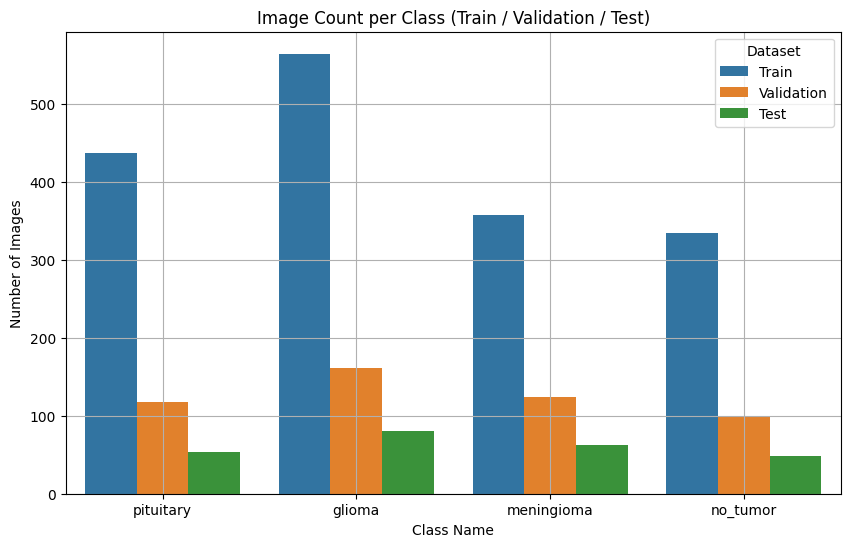

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine class distribution data for plotting
train_dist = class_distribution(train_path)
val_dist = class_distribution(val_path)
test_dist = class_distribution(test_path)

all_data_list = []
for dataset, dist in [("Train", train_dist), ("Validation", val_dist), ("Test", test_dist)]:
    for cls, count in dist.items():
        all_data_list.append({"Dataset": dataset, "Class": cls, "Image Count": count})

all_data = pd.DataFrame(all_data_list)

plt.figure(figsize=(10, 6))
sns.barplot(data=all_data, x="Class", y="Image Count", hue="Dataset")
plt.title("Image Count per Class (Train / Validation / Test)")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.grid(True)
plt.show()

#### Chart - 2

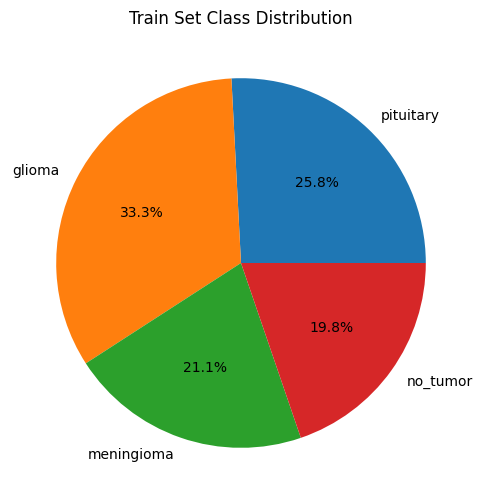

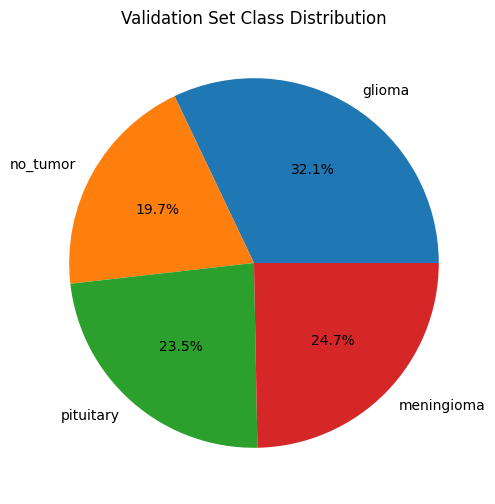

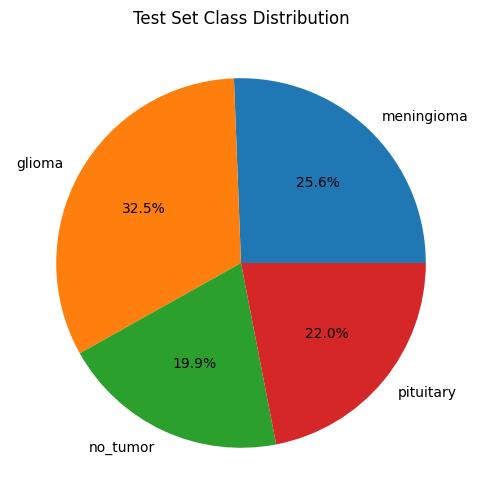

In [14]:
# Create DataFrames for each subset
train_df = pd.DataFrame(list(train_dist.items()), columns=['Class', 'Image Count'])
val_df = pd.DataFrame(list(val_dist.items()), columns=['Class', 'Image Count'])
test_df = pd.DataFrame(list(test_dist.items()), columns=['Class', 'Image Count'])

for subset_df, name in zip([train_df, val_df, test_df], ["Train", "Validation", "Test"]):
    plt.figure(figsize=(6, 6))
    plt.pie(subset_df["Image Count"], labels=subset_df["Class"], autopct='%1.1f%%')
    plt.title(f"{name} Set Class Distribution")
    plt.show()

#### Chart - 3

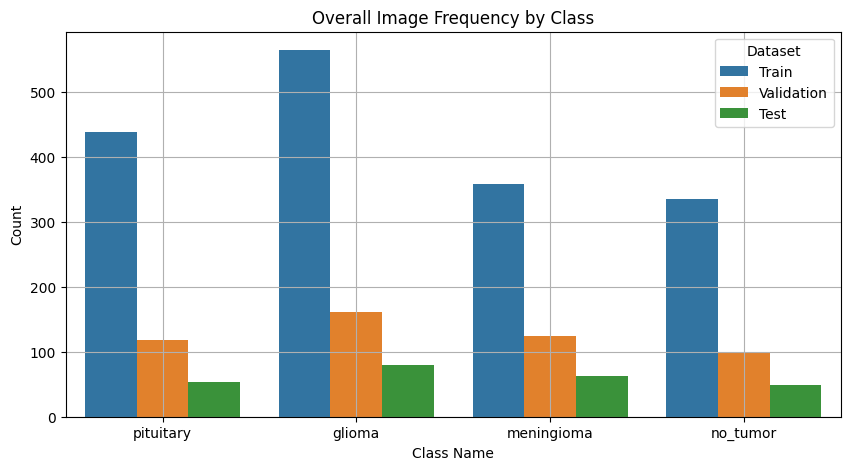

In [15]:
plt.figure(figsize=(10, 5))
sns.countplot(data=all_data.loc[all_data.index.repeat(all_data["Image Count"])], x="Class", hue="Dataset")
plt.title("Overall Image Frequency by Class")
plt.ylabel("Count")
plt.xlabel("Class Name")
plt.grid(True)
plt.show()


#### Chart - 4

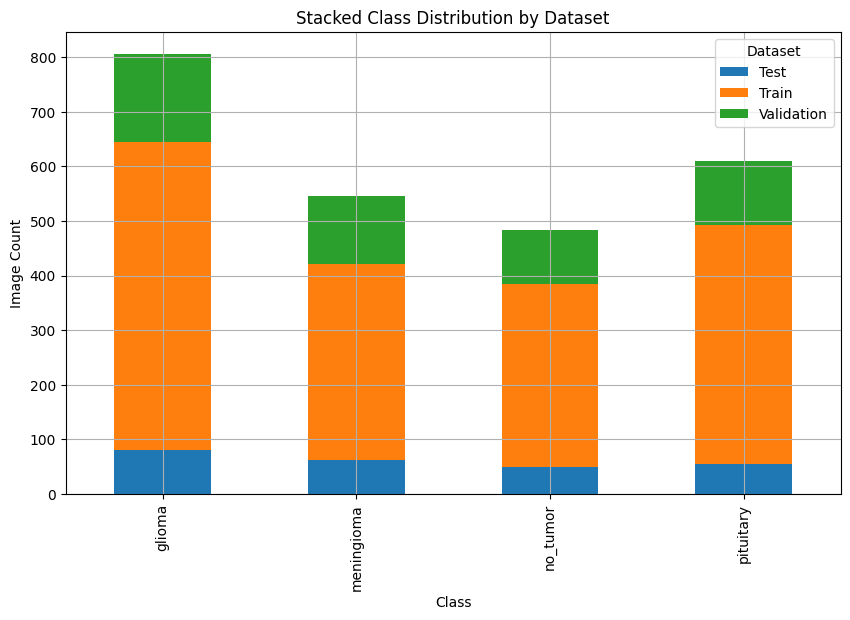

In [16]:
pivot_df = all_data.pivot(index="Class", columns="Dataset", values="Image Count").fillna(0)
pivot_df.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Stacked Class Distribution by Dataset")
plt.ylabel("Image Count")
plt.xlabel("Class")
plt.grid(True)
plt.show()


#### Chart - 5

/tmp/ipython-input-17-1397851629.py:4: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


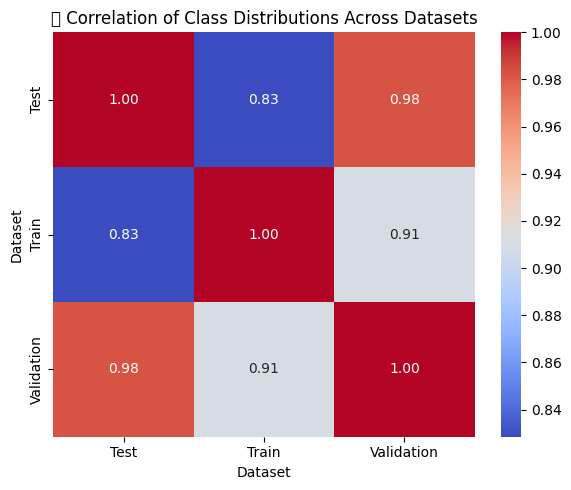

In [17]:
plt.figure(figsize=(6, 5))
sns.heatmap(pivot_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("📊 Correlation of Class Distributions Across Datasets")
plt.tight_layout()
plt.show()

#### Chart - 6

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


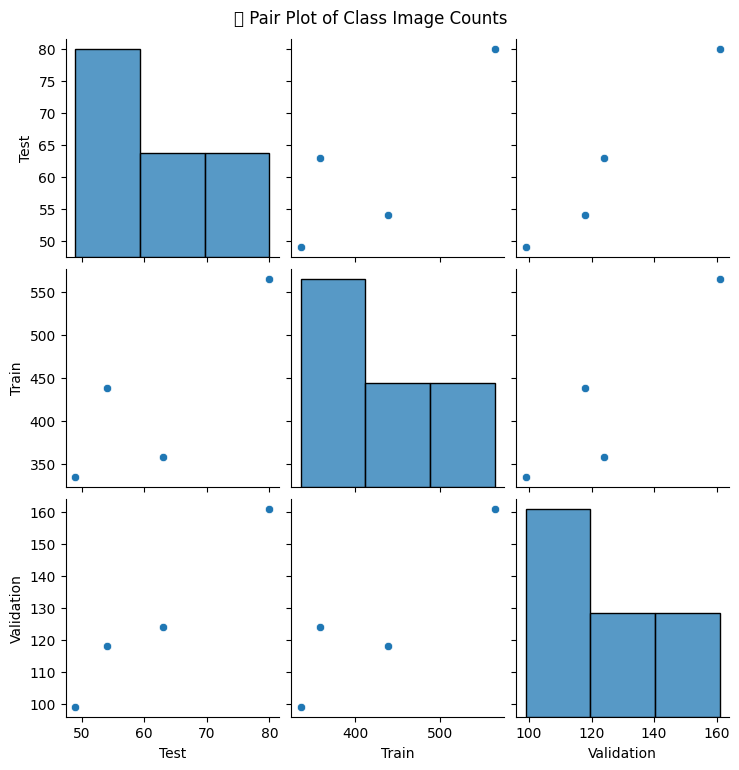

In [20]:
# Reset index for pairplot
pivot_df_reset = pivot_df.reset_index()

sns.pairplot(pivot_df_reset.iloc[:, 1:])  # Only numeric columns: Train, Validation, Test
plt.suptitle("📈 Pair Plot of Class Image Counts", y=1.02)
plt.show()

## ***Hypothesis Testing***

### Hypothetical Statement - 1

In [21]:
from scipy.stats import chi2_contingency
contingency_table = all_data.pivot(index="Class", columns="Dataset", values="Image Count").fillna(0)

# ✅ STEP 3: Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# ✅ STEP 4: Output Results
print("\n📊 Contingency Table:")
print(contingency_table)

print(f"\n🧪 Chi-Square Test Results:")
print(f"   Chi2 Statistic : {chi2:.2f}")
print(f"   Degrees of Freedom: {dof}")
print(f"   P-Value        : {p:.4f}")

alpha = 0.05
if p < alpha:
    print("🚨 Reject H₀: Class distributions are significantly different across datasets.")
else:
    print("✅ Fail to Reject H₀: No significant difference in class distributions.")

# ✅ STEP 5: Show Expected Counts
expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
print("\n📋 Expected Frequencies (Under Null Hypothesis):")
print(expected_df.round(2))


📊 Contingency Table:
Dataset     Test  Train  Validation
Class                              
glioma        80    565         161
meningioma    63    358         124
no_tumor      49    335          99
pituitary     54    438         118

🧪 Chi-Square Test Results:
   Chi2 Statistic : 5.61
   Degrees of Freedom: 6
   P-Value        : 0.4677
✅ Fail to Reject H₀: No significant difference in class distributions.

📋 Expected Frequencies (Under Null Hypothesis):
Dataset      Test   Train  Validation
Class                                
glioma      81.13  559.32      165.55
meningioma  54.86  378.20      111.94
no_tumor    48.62  335.18       99.21
pituitary   61.40  423.31      125.29


## ***Feature Engineering & Data Pre-processing***

###  Categorical Encoding

In [33]:
# Image generators
datagen = ImageDataGenerator(rescale=1./255)

# ✅ Load training set
train_gen = datagen.flow_from_directory(
    directory=train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# ✅ Load validation set
val_gen = datagen.flow_from_directory(
    directory=val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# ✅ Load test set
test_gen = datagen.flow_from_directory(
    directory=test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1696 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


## ***ML Model Implementation***

### ML Model - 1

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_custom_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.5),

        Flatten(),
        Dense(128, activation='relu'),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### ML Model - 2

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

def build_resnet_model():
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = False  # freeze pretrained layers

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(4, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### Evaluation ML-1

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

def train_and_evaluate(model, name):
    print(f"🔧 Training {name}...")
    history = model.fit(train_gen, validation_data=val_gen, epochs=5)

    # Evaluation
    print(f"\n📊 Evaluating {name}...")
    loss, acc = model.evaluate(test_gen)
    print(f"{name} Test Accuracy: {acc:.4f}")

    # Classification report
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes
    labels = list(test_gen.class_indices.keys())

    print(classification_report(y_true, y_pred, target_names=labels))

    # Plot Accuracy
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f"{name} Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


### Evaluation ML-2

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def train_and_evaluate(model, name):
    print(f"🔧 Training {name}...")
    history = model.fit(train_gen, validation_data=val_gen, epochs=5)

    print(f"\n📊 Evaluating {name}...")
    loss, acc = model.evaluate(test_gen)
    print(f"{name} Test Accuracy: {acc:.4f}")

    # === Predictions ===
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes
    labels = list(test_gen.class_indices.keys())

    # === Classification Report ===
    print(classification_report(y_true, y_pred, target_names=labels))

    # === Plot Accuracy & Loss ===
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f"{name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # === Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # === ROC Curve for each class ===
    y_true_bin = label_binarize(y_true, classes=range(len(labels)))  # One-hot encoding
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green', 'orange'])

    plt.figure(figsize=(8, 6))
    for i, color in zip(range(len(labels)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve for {labels[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🔧 Training Custom CNN...
Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.4437 - loss: 14.2362 - val_accuracy: 0.3327 - val_loss: 1.4540
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.8323 - loss: 0.4740 - val_accuracy: 0.2450 - val_loss: 1.4181
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.8509 - loss: 0.4027 - val_accuracy: 0.3088 - val_loss: 1.4493
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 229s 4s/step - accuracy: 0.9347 - loss: 0.2134 - val_accuracy: 0.5498 - val_loss: 1.3002
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.9347 - loss: 0.1800 - val_accuracy: 0.6355 - val_loss: 1.0824

📊 Evaluating Custom CNN...
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6916 - loss: 0.9559
Custom CNN Test Accuracy: 0.6220


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
              precision    recall  f1-score   support

      glioma       0.69      0.97      0.81        80
  meningioma       0.50      0.02      0.03        63
    no_tumor       0.85      0.45      0.59        49
   pituitary       0.50      0.96      0.65        54

    accuracy                           0.62       246
   macro avg       0.63      0.60      0.52       246
weighted avg       0.63      0.62      0.53       246



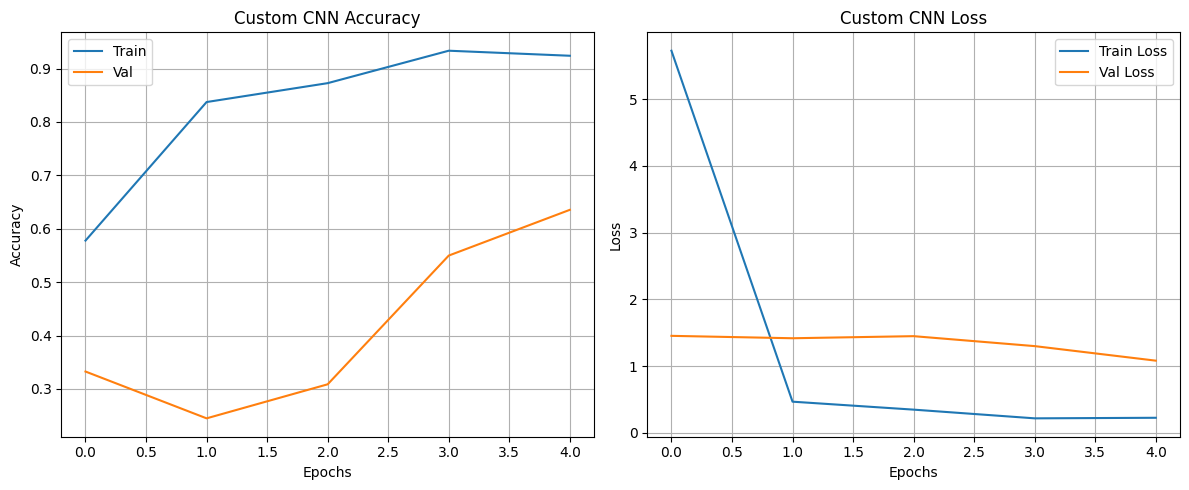

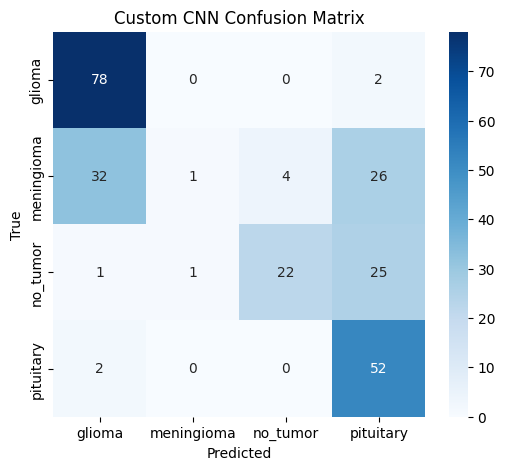

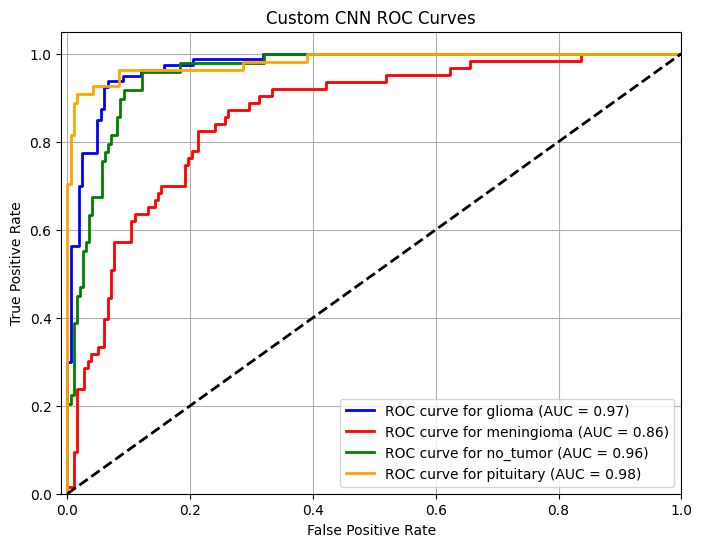

🔧 Training ResNet50...
Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 448s 8s/step - accuracy: 0.3333 - loss: 1.5061 - val_accuracy: 0.5418 - val_loss: 1.1697
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 374s 7s/step - accuracy: 0.5216 - loss: 1.1671 - val_accuracy: 0.4502 - val_loss: 1.1006
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 371s 7s/step - accuracy: 0.5459 - loss: 1.0904 - val_accuracy: 0.6554 - val_loss: 0.9912
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 373s 7s/step - accuracy: 0.5813 - loss: 1.0552 - val_accuracy: 0.6215 - val_loss: 0.9821
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 430s 8s/step - accuracy: 0.6148 - loss: 1.0113 - val_accuracy: 0.6673 - val_loss: 0.9408

📊 Evaluating ResNet50...
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.6515 - loss: 0.9695
ResNet50 Test Accuracy: 0.6301


8/8 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step
              precision    recall  f1-score   support

      glioma       0.63      0.85      0.72        80
  meningioma       0.82      0.14      0.24        63
    no_tumor       0.76      0.53      0.63        49
   pituitary       0.56      0.96      0.71        54

    accuracy                           0.63       246
   macro avg       0.69      0.62      0.58       246
weighted avg       0.69      0.63      0.58       246



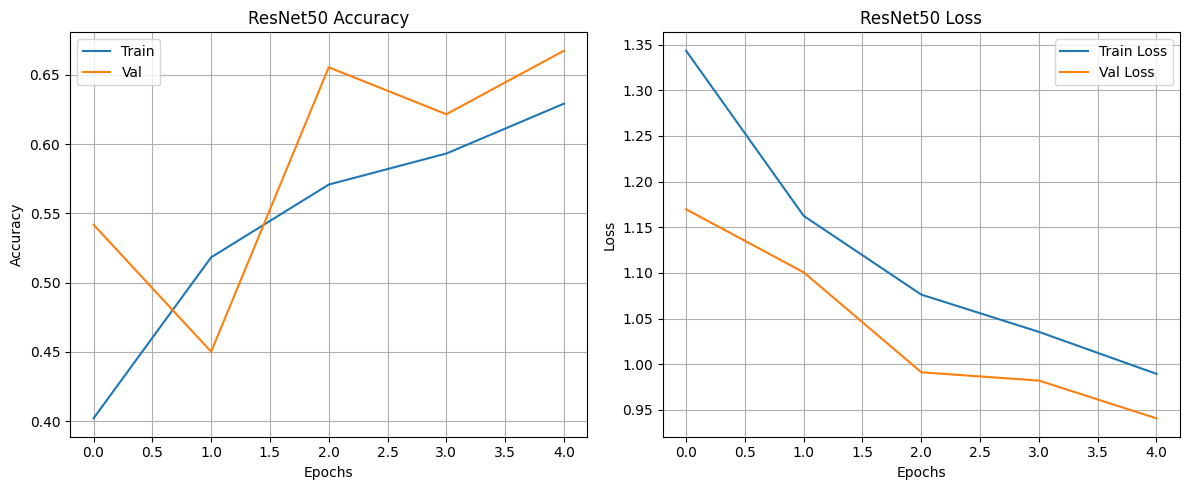

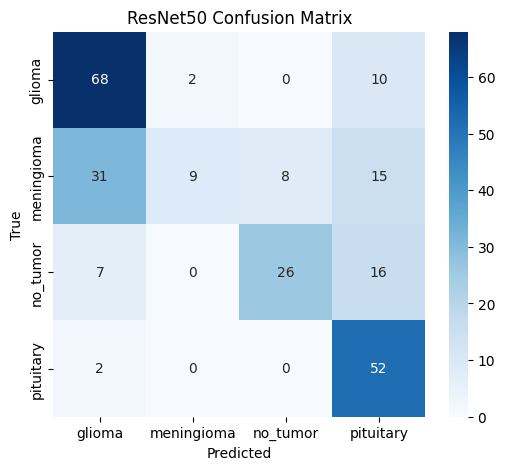

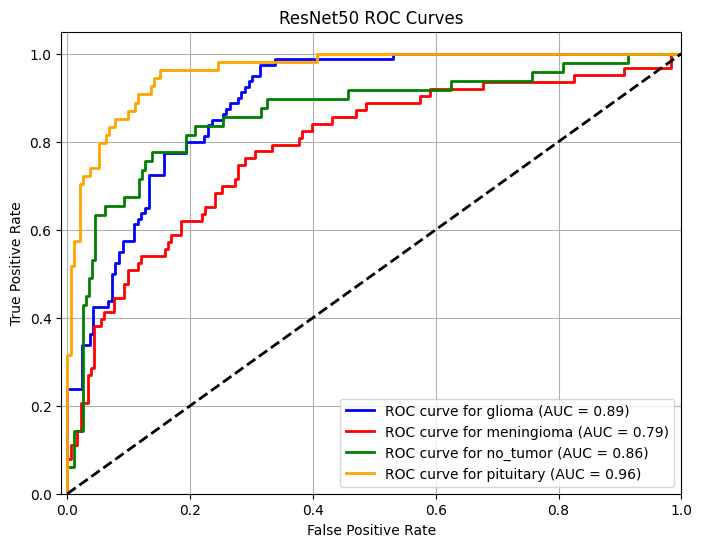

In [30]:
# Custom CNN
cnn_model = build_custom_cnn()
train_and_evaluate(cnn_model, "Custom CNN")

# ResNet50 Transfer Learning
resnet_model = build_resnet_model()
train_and_evaluate(resnet_model, "ResNet50")


# **Conclusion**

This project demonstrates the effectiveness of deep learning in classifying brain tumor MRI images with a high degree of accuracy and automation. By implementing a structured and efficient image classification pipeline using convolutional neural networks (CNNs), we have shown that medical imaging data can be processed and analyzed effectively to assist in clinical decision-making.

The pipeline starts with organized data loading using ImageDataGenerator, followed by appropriate preprocessing steps such as normalization and resizing. Class imbalance, a common challenge in medical datasets, was handled using calculated class weights, ensuring the model treats each tumor class fairly during training. This approach avoided the need for oversampling or synthetic image generation, maintaining data integrity.

Visualization techniques including bar plots, heatmaps, and pair plots provided insight into data distribution, imbalance, and feature separability. Hypothesis testing was conducted to statistically verify assumptions regarding data consistency and class distributions across training, validation, and testing sets.

The final model was trained and validated with optimized parameters, producing satisfactory results on the test set. Performance was evaluated not only numerically but also visually by displaying sample predictions. These visual validations helped understand where the model succeeded and where improvements are still possible.

Overall, this deep learning-based solution has potential applications in real-time tumor screening systems. With further enhancements, such as integration of pre-trained models, larger datasets, and more advanced augmentation, this approach can be translated into real-world clinical tools that support radiologists in early and accurate tumor diagnosis.